In [27]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
from gurobipy import *

In [28]:
# data_generation_process = "SPO_Data_Generation"
data_generation_process = "DDR_Data_Generation"

# Parameters

In [11]:
# import pyepo
# generate data
grid = (3,3) # grid size
num_train = 100 # number of training data
num_feat = 5 # size of feature
num_test = 10000
deg = 1.2 # polynomial degree
e = 1 # scale of normal std or the range of uniform. For the error term

lower = 0 # coef lower bound
upper = 1 # coef upper bound
p = num_feat # num of features
d = 12 # num of arcs
alpha = e # scale of normal std or the range of uniform. For the error term
mis = deg # model misspecification


In [16]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
grandparent_directory = os.path.dirname(parent_directory)
DataPath = os.path.dirname(grandparent_directory) + '/Data/Test_0316' + data_generation_process + "/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
print("grandparent_directory:", grandparent_directory)
print("DataPath:", DataPath)

DataPath = DataPath + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)

grandparent_directory: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Code_MacBook
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Test_0316DDR_Data_Generation/


# Generate Data

In [17]:
def Prepare_Data(DataPath,lower, upper, p, d, coef_seed,seed_all,num_test, num_train, alpha,mis,data_generation_process):
# #  ****** Coef generation *********
    from Data import data_generation
    data_gen = data_generation()
    # print("W_star = ",W_star[0,:])
    W_star = data_gen.generate_truth(DataPath,lower, upper, p, d, coef_seed,version = 0) 

    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        # #  ****** Data generation *********
        x_test, c_test, x_train, c_train, W_star = data_gen.generate_samples(seed,DataPath_seed,p, d, num_test, num_train, alpha, W_star, mis, thres = 10, 
                                version = data_generation_process, x_dist = 'normal', e_dist = 'normal', x_low = 0, x_up = 2, x_mean = 2, x_var = 0.25, bump = 0) 
        # print()
    return x_test, c_test, x_train, c_train, W_star

In [18]:
coef_seed = 1
seed_all = [1]
x_test, c_test, x_train, c_train, W_star = Prepare_Data(DataPath,lower, upper, p, d, coef_seed,seed_all,num_test, num_train, alpha,mis,data_generation_process)

# Obtain OLS estimation

In [20]:
from OLS import ols_method
ols_method_obj = ols_method()
W_ols, w0_ols, t_ols, obj_ols = ols_method_obj.ols_solver("",x_train, c_train)

In [23]:
c_ols_esti = np.zeros((num_train,12))
for i in range(num_train):
    for j in range(12):
        c_ols_esti[i,j] = sum([W_ols[j][k] * x_train[i,k] for k in range(num_feat)])+ w0_ols[j]

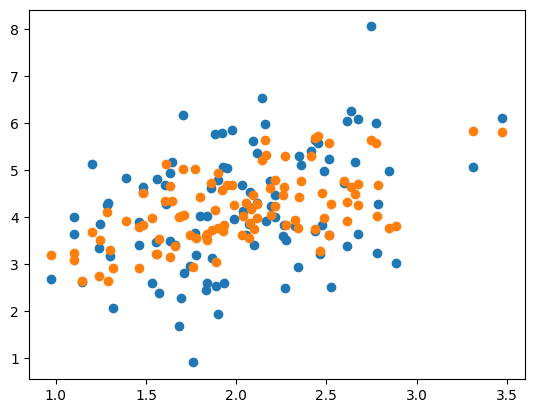

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot()
ax.scatter(x_train[:,0],c_train[:,0])
ax.scatter(x_train[:,0],c_ols_esti[:,0])

In [ ]:
def _getArcs(grid):
    arcs = []
    for i in range(grid[0]):
        # edges on rows
        for j in range(grid[1] - 1):
            v = i * grid[1] + j
            arcs.append((v, v + 1))
        # edges in columns
        if i == grid[0] - 1:
            continue
        for j in range(grid[1]):
            v = i * grid[1] + j
            arcs.append((v, v + grid[1]))
    return arcs

In [ ]:
arcs = _getArcs(grid)

# Obtain DDR estimation

In [ ]:
def solve_DDR(arcs,lamb,mu_fixed,num_nodes,x_train,c_train):
    
    N,p = x_train.shape
    N,d = c_train.shape

    # DDR
    m = Model("ddr")
    #m.setParam("DualReductions",0)
    m.setParam('OutputFlag', 0)

    W_ind = tuplelist( [(i,j) for i in range(d) for j in range(p)] )
    w0_ind = tuplelist( [i for i in range(d)])

    W_ddr = m.addVars( W_ind, lb=-GRB.INFINITY,name = "W" )
    w0_ddr = m.addVars( w0_ind, lb=-GRB.INFINITY,name = "W0" )
    alpha = m.addVars(N,num_nodes,lb=-GRB.INFINITY,name="alpha")
    expr_obj = 0
    err = []
    for n in range(N):
        cost_true_tem = c_train[n]
        expr_obj = expr_obj + alpha[n,num_nodes-1] - alpha[n,0]
        for ind in range(len(arcs)):
            cost_pred_tem = quicksum([W_ddr[ind,j] * x_train[n,j] for j in range(p)]) + w0_ddr[ind]
            err.append(cost_true_tem[ind] - cost_pred_tem)
            e = arcs[ind]
            j = e[1]
            i = e[0]
            # print("j = ",j,", i = ",i, ", e = ",e)
            m.addConstr(alpha[n,j] - alpha[n,i] >= -mu_fixed*cost_true_tem[ind] - (1-mu_fixed)*cost_pred_tem)

    m.setObjective(quicksum([err[k] * err[k] for k in range(len(err))])/N + lamb*(expr_obj)/N, GRB.MINIMIZE)
    m.optimize()
    
    W_DDR_rst = m.getAttr('x', W_ddr)
    w0_DDR_rst = m.getAttr('x', w0_ddr)
    # W_ddr_val = []
    # for i in range(d):
    #     W_ddr_val.append([W_DDR_rst[(i,j)] for j in range(p)])
    # w0_ddr_val = [w0_DDR_rst[i] for i in range(d)]

    alpha_rst = m.getAttr('x', alpha)
    # alpha_rst = np.zeros((N,num_nodes))
    # for n in range(N):
    #     for node_index in range(num_nodes):
    #         alpha_rst = m.
    return w0_DDR_rst,W_DDR_rst,alpha_rst

    # return w0_ddr_val,W_ddr_val,alpha_rst

In [ ]:
lamb = 1
mu_fixed = 0.8
num_nodes = 9
w0_ddr_val,W_ddr_val,alpha_rst = solve_DDR(arcs,lamb,mu_fixed,num_nodes,x_train,c_train)

In [ ]:
W_ddr_val[11,0] * (-0.7921433462295078) + w0_ddr_val[11]

In [ ]:
c_train[-1,:]

In [ ]:
lamb = 1
mu_arr = np.arange(-1.0,1.01,0.05)
num_nodes = 9
w0_ddr_dict = {}
W_ddr_dict = {}
for mu_fixed in mu_arr:
    w0_ddr_dict[mu_fixed],W_ddr_dict[mu_fixed],alpha_rst = solve_DDR(arcs,lamb,mu_fixed,num_nodes,x_train,c_train)

In [ ]:
cost_ddr_dict = []
for mu_fixed in mu_arr:
    cost_ddr_solved = 0
    for i in range(num_train):
        for j in range(12):
            cost_pred = W_ddr_val[j,0] * x_train[i,0] + w0_ddr_val[j]
            cost_ddr_solved = cost_ddr_solved + (mu_fixed - 1) * cost_pred - mu_fixed * c_train[i,j]
    cost_ddr_dict.append(cost_ddr_solved/num_train)

In [ ]:
cost_ols_solved = 0
cost_oracel_solved = 0
for i in range(num_train):
    for j in range(12):
        cost_pred = W_ols[j][0] * x_train[i,0] + w0_ols[j]
        cost_ols_solved = cost_ols_solved + cost_pred
        cost_oracel_solved = cost_oracel_solved - c_train[i,j]

In [ ]:
cost_ols_solved/num_train

In [ ]:
cost_oracel_solved/num_train

In [ ]:
i = 1
j = 0
W_ols[j][0] * x_train[i,0] + w0_ols[j]

In [ ]:
c_train[i,j]

In [ ]:
c_ols = np.zeros(np.shape(c_train))
c_ddr = np.zeros(np.shape(c_train))
for j in range(np.shape(x_train)[0]):
    c_ols[j,:] = W_ols @ x_train[j,:] + w0_ols
    c_ddr[j,:] = W_ddr_val @ x_train[j,:] + w0_ddr_val

In [ ]:
c_ddr[j,:]

In [ ]:
c_ols[j,:]

# Solve Shortest Path

In [ ]:
def solve_Shortest_Path(arcs,cost,grid):

    import gurobipy as gp
    from gurobipy import GRB
    # ceate a model
    m = gp.Model("shortest path")
    m.setParam('OutputFlag', 0)
    # varibles
    x = m.addVars(arcs, name="x")
    # sense
    # m.modelSense = GRB.MINIMIZE
    # flow conservation constraints
    for i in range(grid[0]):
        for j in range(grid[1]):
            v = i * grid[1] + j
            expr = 0
            for e in arcs:
                # flow in
                if v == e[1]:
                    expr += x[e]
                # flow out
                elif v == e[0]:
                    expr -= x[e]
            # source
            if i == 0 and j == 0:
                m.addConstr(expr == -1)
            # sink
            elif i == grid[0] - 1 and j == grid[0] - 1:
                m.addConstr(expr == 1)
            # transition
            else:
                m.addConstr(expr == 0)
    m.setObjective( sum([cost[ind] * x[arcs[ind]] for ind in range(len(arcs))]) , GRB.MINIMIZE)
    m.optimize()
    sol = m.getAttr('x')
    # print("sol = ",sol)
    # print("shortest_path = ",shortest_path)
    return sol,m.objVal

In [ ]:
j = 2
sol_oracle,obj_oracle = solve_Shortest_Path(arcs,c_train[j,:],grid)
sol_ols,obj_ols = solve_Shortest_Path(arcs,c_ols[j,:],grid)
sol_ddr,obj_ddr = solve_Shortest_Path(arcs,c_ddr[j,:],grid)

In [ ]:
print("obj_oracle = ",obj_oracle,", obj_ols = ",obj_ols, ", obj_ddr = ",obj_ddr)

In [ ]:
sol_oracle

In [ ]:
sol_ddr

In [ ]:
sol_ols

In [ ]:
c_train[j,:]

In [ ]:
np.asarray(sol_oracle) @ c_train[j,:]

In [ ]:
np.asarray(sol_ddr) @ c_train[j,:]

In [ ]:
np.asarray(sol_ols) @ c_train[j,:]